In [ ]:
# 1. Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import joblib

In [ ]:
# 2. Cargar dataset
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/DATASETS/SALUD/healthcare_dataset.csv")

print("Dimensiones del dataset:", df.shape)
print(df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dimensiones del dataset: (55500, 15)
            Name  Age  Gender Blood Type Medical Condition Date of Admission  \
0  Bobby JacksOn   30    Male         B-            Cancer        2024-01-31   
1   LesLie TErRy   62    Male         A+           Obesity        2019-08-20   
2    DaNnY sMitH   76  Female         A-           Obesity        2022-09-22   
3   andrEw waTtS   28  Female         O+          Diabetes        2020-11-18   
4  adrIENNE bEll   43  Female        AB+            Cancer        2022-09-19   

             Doctor                    Hospital Insurance Provider  \
0     Matthew Smith             Sons and Miller         Blue Cross   
1   Samantha Davies                     Kim Inc           Medicare   
2  Tiffany Mitchell                    Cook PLC              Aetna   
3       Kevin Wells  Hernandez Rogers and Vang,           Medicare   
4  

In [ ]:
# 3. Exploración de Datos (EDA)

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 6.4

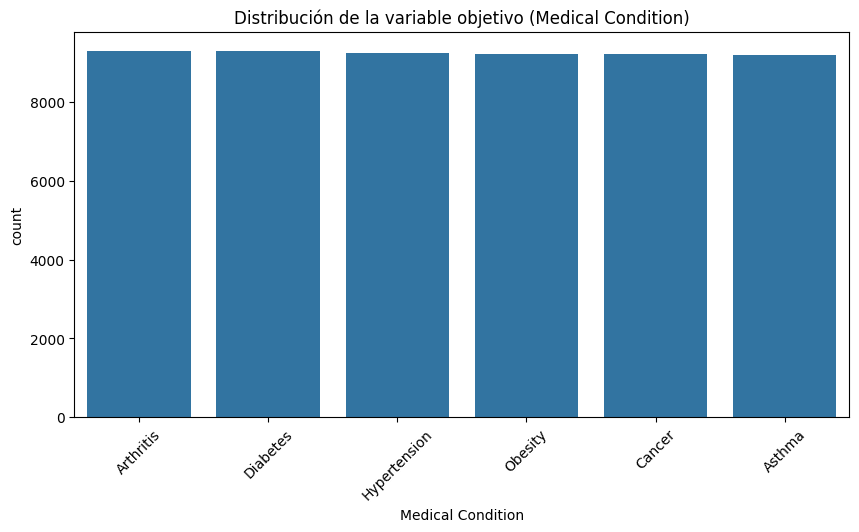

In [ ]:
# Ver distribución de la variable objetivo (Medical Condition)
plt.figure(figsize=(10,5))
sns.countplot(x="Medical Condition", data=df, order=df["Medical Condition"].value_counts().index)
plt.title("Distribución de la variable objetivo (Medical Condition)")
plt.xticks(rotation=45)
plt.show()

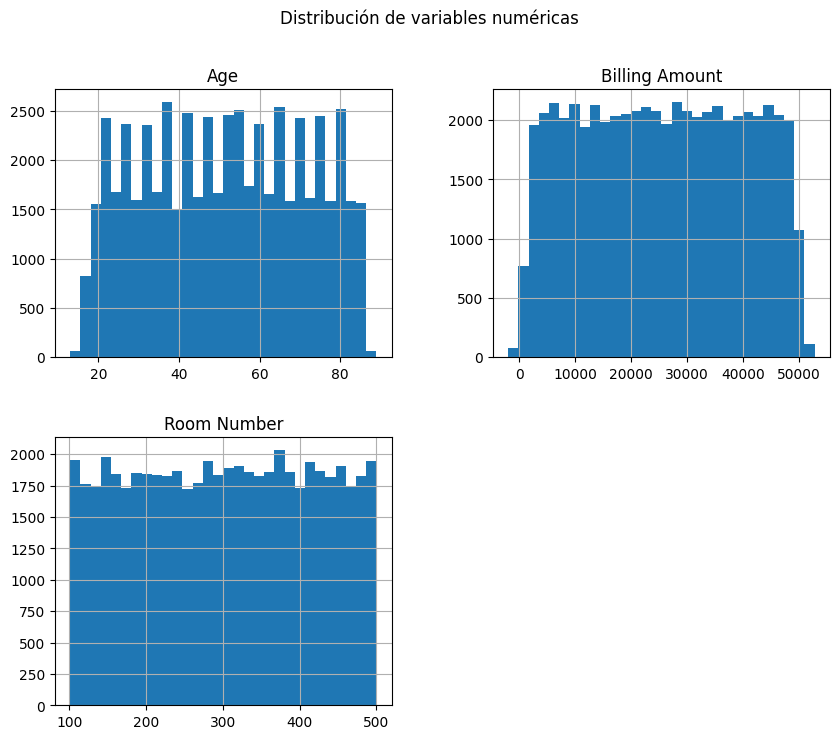

In [ ]:
# Histogramas de variables numéricas disponibles
df[["Age", "Billing Amount", "Room Number"]].hist(bins=30, figsize=(10,8))
plt.suptitle("Distribución de variables numéricas")
plt.show()


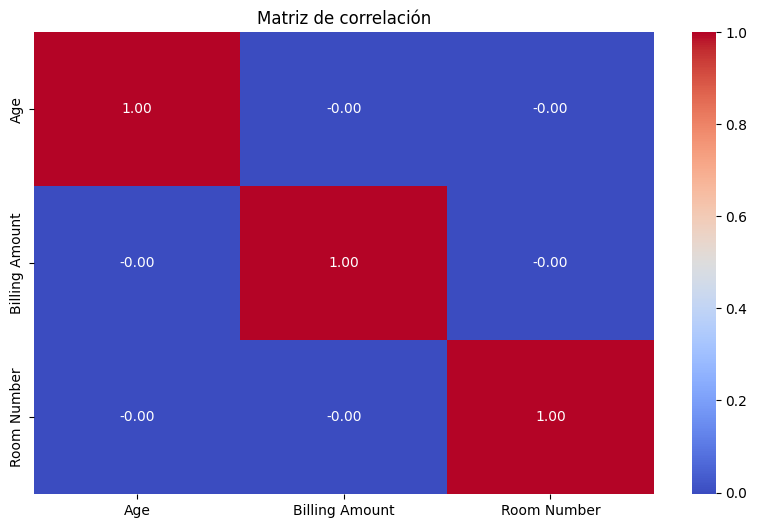

In [ ]:
# Matriz de correlación solo con variables numéricas
plt.figure(figsize=(10,6))
sns.heatmap(df[["Age", "Billing Amount", "Room Number"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

In [ ]:
# 4. Limpieza y Preparación
# Manejo de nulos
print("Valores nulos por columna:\n", df.isnull().sum())

# Eliminar duplicados
df = df.drop_duplicates()


Valores nulos por columna:
 Name                  0
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Date of Admission     0
Doctor                0
Hospital              0
Insurance Provider    0
Billing Amount        0
Room Number           0
Admission Type        0
Discharge Date        0
Medication            0
Test Results          0
dtype: int64


In [ ]:
# Definir variable objetivo y predictores
y = df["Medical Condition"]
X = df.drop(columns=["Medical Condition"])

# Separar columnas numéricas y categóricas
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

print("Columnas numéricas:", list(num_cols))
print("Columnas categóricas:", list(cat_cols))

Columnas numéricas: ['Age', 'Billing Amount', 'Room Number']
Columnas categóricas: ['Name', 'Gender', 'Blood Type', 'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider', 'Admission Type', 'Discharge Date', 'Medication', 'Test Results']


In [ ]:
# =============================
# ONE HOT ENCODING
# =============================

# Variable objetivo
y = df["Medical Condition"]

# Variables predictoras
X = df.drop("Medical Condition", axis=1)

# Seleccionamos solo las columnas categóricas relevantes
categorical_cols = ["Gender", "Blood Type",
                    "Admission Type", "Medication", "Test Results"]

# One Hot Encoding (drop_first=True evita colinealidad)
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("Shape original:", X.shape)
print("Shape después de OHE:", X_encoded.shape)

Shape original: (54966, 8)
Shape después de OHE: (54966, 19)


In [ ]:
# ====================================================
# 1. Eliminar columnas irrelevantes con texto libre
# ====================================================
cols_to_drop = ["Name", "Doctor", "Hospital", "Insurance Provider",
                "Date of Admission", "Discharge Date"]
df = df.drop(columns=cols_to_drop, errors="ignore")

# ====================================================
# 2. Separar X e y
# ====================================================
X = df.drop("Medical Condition", axis=1)  # features
y = df["Medical Condition"]               # target

# ====================================================
# 3. Preprocesamiento y split
# ====================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identificar tipos de variables
categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(include=["int64","float64"]).columns

# Definir transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols)
    ]
)


In [ ]:
# Escalar SOLO las variables numéricas
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

In [ ]:
# ===============================
# Dividir en Train/Test
# ===============================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pandas as pd

# One Hot Encoding para variables categóricas en X
cat_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)


# Separar en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

print("Shape de Train:", X_train.shape, " | Shape de Test:", X_test.shape)


# ===============================
# Codificar variable objetivo
# ===============================
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)


# ===============================
# Modelos
# ===============================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Modelo 1: Regresión Logística
log_reg = LogisticRegression(
    max_iter=10000,        # más iteraciones para convergencia
    solver="saga",         # solver robusto para datasets grandes/multiclase
    random_state=42
)

log_reg.fit(X_train, y_train_enc)
y_pred_lr = log_reg.predict(X_test)

# Modelo 2: Random Forest
rf = RandomForestClassifier(
    n_estimators=300,      # más árboles para estabilidad
    random_state=42
)

rf.fit(X_train, y_train_enc)
y_pred_rf = rf.predict(X_test)

# Modelo 3: XGBoost
xgb = XGBClassifier(
    eval_metric="mlogloss",
    random_state=42
)

xgb.fit(X_train, y_train_enc)
y_pred_xgb = xgb.predict(X_test)


# ===============================
# Decodificar predicciones a etiquetas originales
# ===============================
y_pred_lr_labels  = le.inverse_transform(y_pred_lr)
y_pred_rf_labels  = le.inverse_transform(y_pred_rf)
y_pred_xgb_labels = le.inverse_transform(y_pred_xgb)


Shape de Train: (46721, 19)  | Shape de Test: (8245, 19)



===== Logistic Regression =====
Accuracy: 0.17089144936325046
Reporte de clasificación:
               precision    recall  f1-score   support

   Arthritis       0.22      0.04      0.07      1383
      Asthma       0.00      0.00      0.00      1364
      Cancer       0.17      0.34      0.23      1371
    Diabetes       0.17      0.26      0.20      1382
Hypertension       0.16      0.21      0.18      1373
     Obesity       0.18      0.17      0.17      1372

    accuracy                           0.17      8245
   macro avg       0.15      0.17      0.14      8245
weighted avg       0.15      0.17      0.14      8245



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


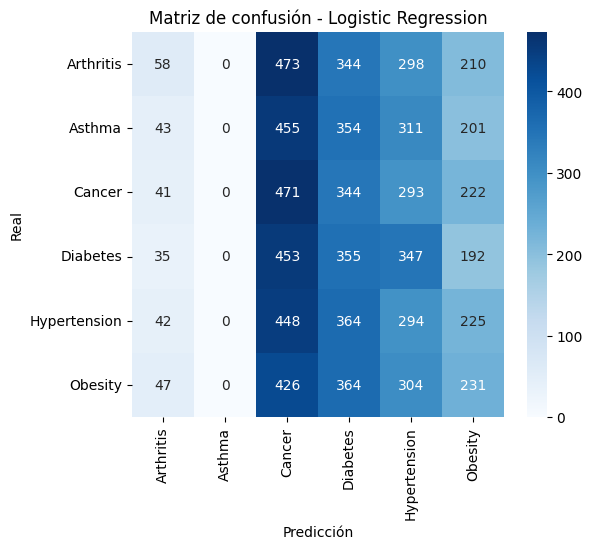


===== Random Forest =====
Accuracy: 0.29314736203759856
Reporte de clasificación:
               precision    recall  f1-score   support

   Arthritis       0.26      0.27      0.27      1383
      Asthma       0.29      0.29      0.29      1364
      Cancer       0.31      0.31      0.31      1371
    Diabetes       0.29      0.30      0.29      1382
Hypertension       0.30      0.30      0.30      1373
     Obesity       0.31      0.29      0.30      1372

    accuracy                           0.29      8245
   macro avg       0.29      0.29      0.29      8245
weighted avg       0.29      0.29      0.29      8245



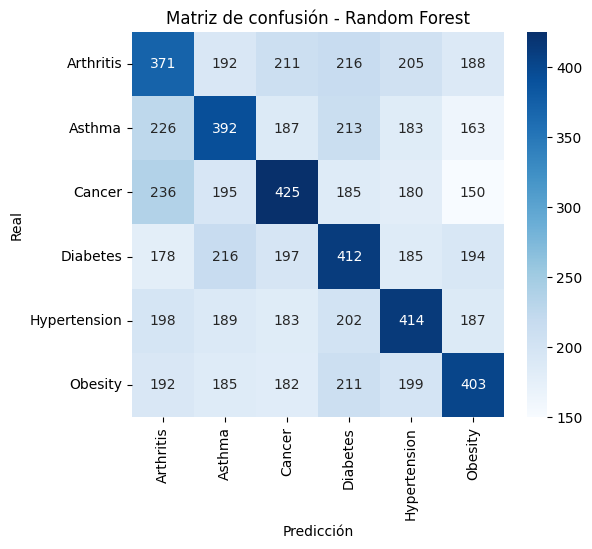


===== XGBoost =====
Accuracy: 0.200970285021225
Reporte de clasificación:
               precision    recall  f1-score   support

   Arthritis       0.20      0.19      0.20      1383
      Asthma       0.19      0.20      0.19      1364
      Cancer       0.20      0.19      0.20      1371
    Diabetes       0.21      0.22      0.22      1382
Hypertension       0.21      0.20      0.21      1373
     Obesity       0.20      0.20      0.20      1372

    accuracy                           0.20      8245
   macro avg       0.20      0.20      0.20      8245
weighted avg       0.20      0.20      0.20      8245



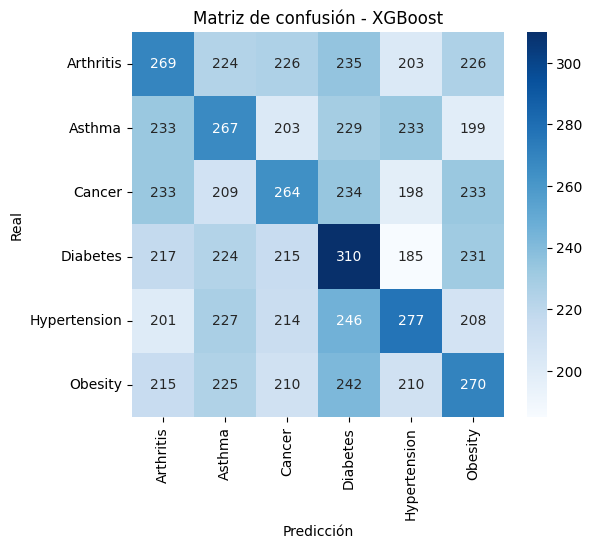

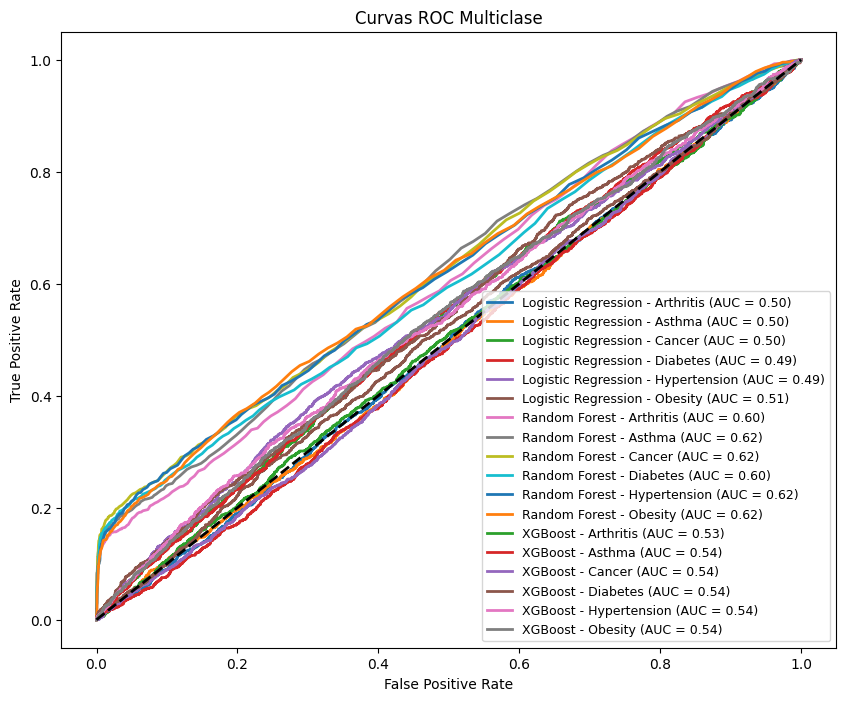

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Lista de modelos y predicciones
modelos = {
    "Logistic Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb
}

# Evaluación de cada modelo
for nombre, y_pred in modelos.items():
    print(f"\n===== {nombre} =====")
    print("Accuracy:", accuracy_score(y_test_enc, y_pred))
    print("Reporte de clasificación:\n", classification_report(y_test_enc, y_pred, target_names=le.classes_))

    # Matriz de confusión
    cm = confusion_matrix(y_test_enc, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Matriz de confusión - {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

# ============================================
# Curvas ROC para multiclase
# ============================================
# Binarizar las etiquetas para ROC (One-vs-Rest)
y_test_bin = label_binarize(y_test_enc, classes=np.arange(len(le.classes_)))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10,8))

for nombre, y_pred in modelos.items():
    # Probabilidades de cada clase
    if nombre == "Logistic Regression":
        y_score = log_reg.predict_proba(X_test)
    elif nombre == "Random Forest":
        y_score = rf.predict_proba(X_test)
    else:  # XGBoost
        y_score = xgb.predict_proba(X_test)

    # Curva ROC por clase
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{nombre} - {le.classes_[i]} (AUC = {roc_auc:.2f})")

# Línea base
plt.plot([0,1], [0,1], "k--", lw=2)
plt.title("Curvas ROC Multiclase")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize=9)
plt.show()



Resumen comparativo de Accuracy:
                Modelo  Accuracy
0  Logistic Regression  0.170891
1        Random Forest  0.293147
2              XGBoost  0.200970


/tmp/ipython-input-2280562402.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y="Accuracy", data=df_resultados, palette="viridis")


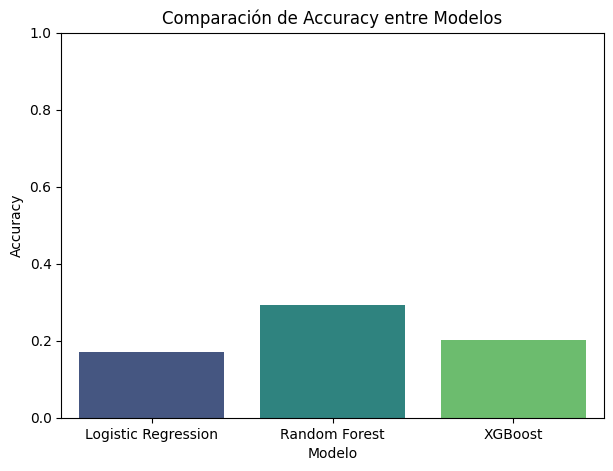

/tmp/ipython-input-2280562402.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_probas.melt(id_vars="Modelo"), x="Modelo", y="value", palette="Set2")


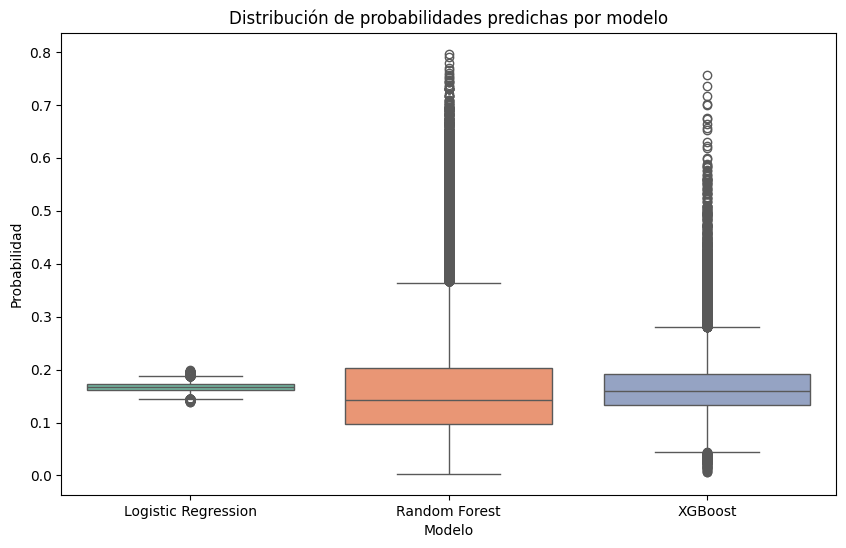

In [ ]:
from sklearn.metrics import accuracy_score
import pandas as pd

# ======================================================
# 1. Tabla resumen de accuracy
# ======================================================
resultados = {
    "Modelo": [],
    "Accuracy": []
}

for nombre, y_pred in modelos.items():
    acc = accuracy_score(y_test_enc, y_pred)
    resultados["Modelo"].append(nombre)
    resultados["Accuracy"].append(acc)

df_resultados = pd.DataFrame(resultados)
print("\nResumen comparativo de Accuracy:")
print(df_resultados)

# ======================================================
# 2. Gráfico de barras de accuracy
# ======================================================
plt.figure(figsize=(7,5))
sns.barplot(x="Modelo", y="Accuracy", data=df_resultados, palette="viridis")
plt.title("Comparación de Accuracy entre Modelos")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.show()

# ======================================================
# 3. Boxplot de probabilidades predichas
# ======================================================
plt.figure(figsize=(10,6))

# Obtener probabilidades de cada modelo
probas = {
    "Logistic Regression": log_reg.predict_proba(X_test),
    "Random Forest": rf.predict_proba(X_test),
    "XGBoost": xgb.predict_proba(X_test)
}

# Convertir a dataframe para boxplot
df_probas = []
for nombre, p in probas.items():
    df_temp = pd.DataFrame(p, columns=le.classes_)
    df_temp["Modelo"] = nombre
    df_probas.append(df_temp)

df_probas = pd.concat(df_probas, ignore_index=True)

# Graficar
sns.boxplot(data=df_probas.melt(id_vars="Modelo"), x="Modelo", y="value", palette="Set2")
plt.title("Distribución de probabilidades predichas por modelo")
plt.ylabel("Probabilidad")
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Métricas por clase y modelo:
                Modelo         Clase  Precision    Recall  F1-score
0  Logistic Regression     Arthritis   0.218045  0.041938  0.070346
1  Logistic Regression        Asthma   0.000000  0.000000  0.000000
2  Logistic Regression        Cancer   0.172781  0.343545  0.229924
3  Logistic Regression      Diabetes   0.167059  0.256874  0.202452
4  Logistic Regression  Hypertension   0.159177  0.214130  0.182609


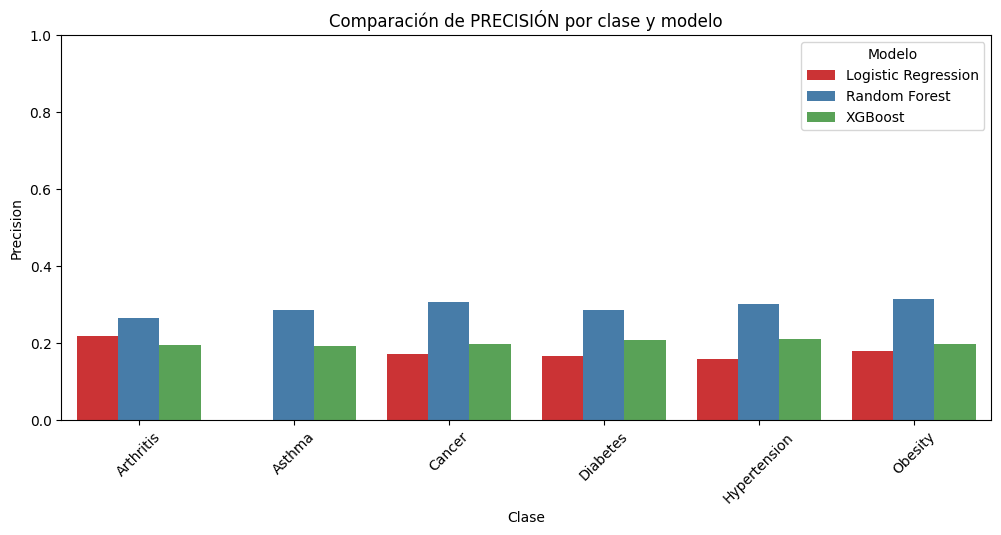

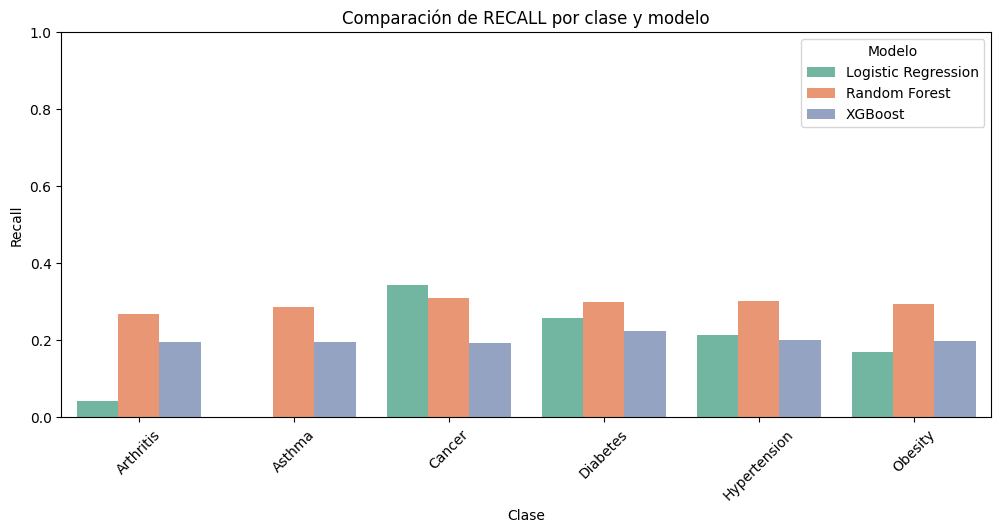

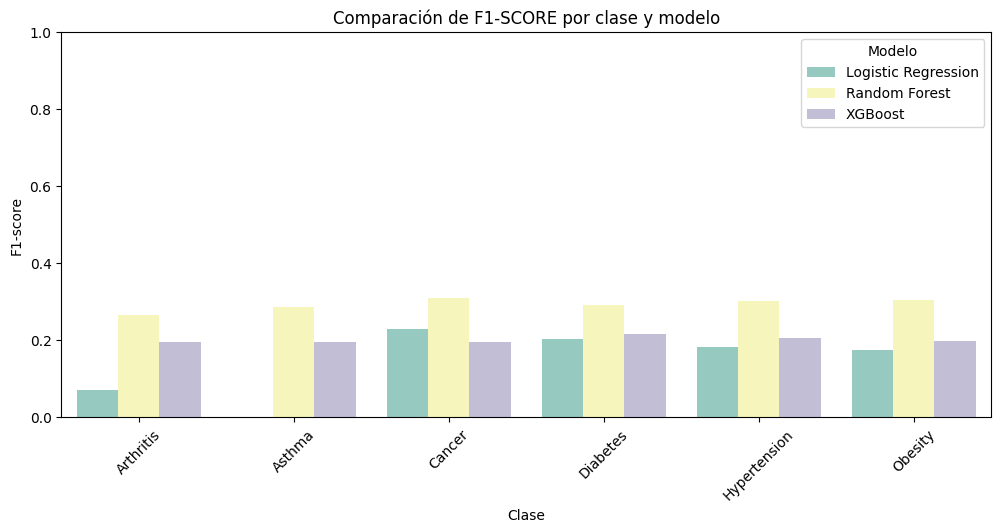

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# ======================================================
# 1. Calcular métricas por clase y modelo
# ======================================================
metricas = []

for nombre, y_pred in modelos.items():
    precision = precision_score(y_test_enc, y_pred, average=None)
    recall = recall_score(y_test_enc, y_pred, average=None)
    f1 = f1_score(y_test_enc, y_pred, average=None)

    for i, clase in enumerate(le.classes_):
        metricas.append({
            "Modelo": nombre,
            "Clase": clase,
            "Precision": precision[i],
            "Recall": recall[i],
            "F1-score": f1[i]
        })

df_metricas = pd.DataFrame(metricas)
print("\nMétricas por clase y modelo:")
print(df_metricas.head())

# ======================================================
# 2. Graficar comparación por métrica
# ======================================================

plt.figure(figsize=(12,5))
sns.barplot(data=df_metricas, x="Clase", y="Precision", hue="Modelo", palette="Set1")
plt.title("Comparación de PRECISIÓN por clase y modelo")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(12,5))
sns.barplot(data=df_metricas, x="Clase", y="Recall", hue="Modelo", palette="Set2")
plt.title("Comparación de RECALL por clase y modelo")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(12,5))
sns.barplot(data=df_metricas, x="Clase", y="F1-score", hue="Modelo", palette="Set3")
plt.title("Comparación de F1-SCORE por clase y modelo")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.show()


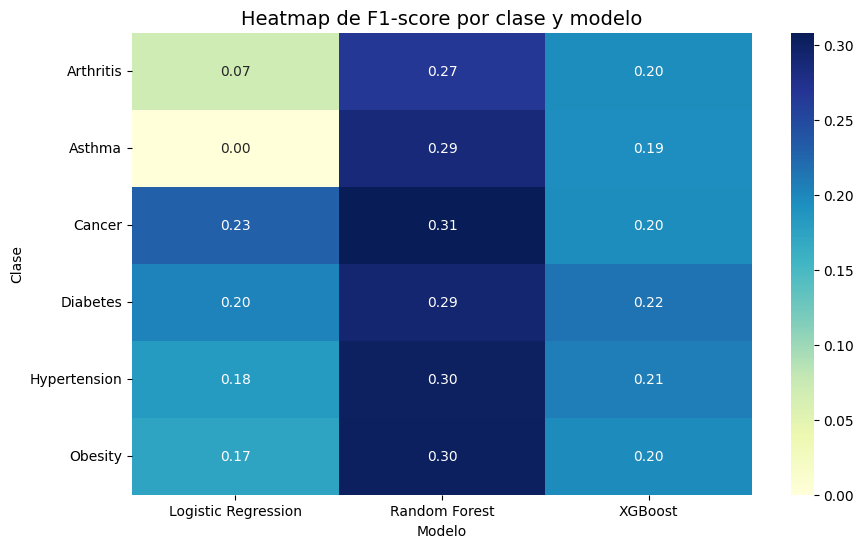

In [ ]:
# ======================================================
# Heatmap de F1-scores
# ======================================================

# Crear tabla pivote: clases en filas, modelos en columnas
pivot_f1 = df_metricas.pivot(index="Clase", columns="Modelo", values="F1-score")

plt.figure(figsize=(10,6))
sns.heatmap(pivot_f1, annot=True, cmap="YlGnBu", fmt=".2f", cbar=True)
plt.title("Heatmap de F1-score por clase y modelo", fontsize=14)
plt.ylabel("Clase")
plt.xlabel("Modelo")
plt.show()


🏆 Ranking de ganadores por clase:
          Clase         Modelo  F1-score
0     Arthritis  Random Forest  0.266523
1        Asthma  Random Forest  0.286864
2        Cancer  Random Forest  0.308418
3      Diabetes  Random Forest  0.292095
4  Hypertension  Random Forest  0.302300
5       Obesity  Random Forest  0.303350


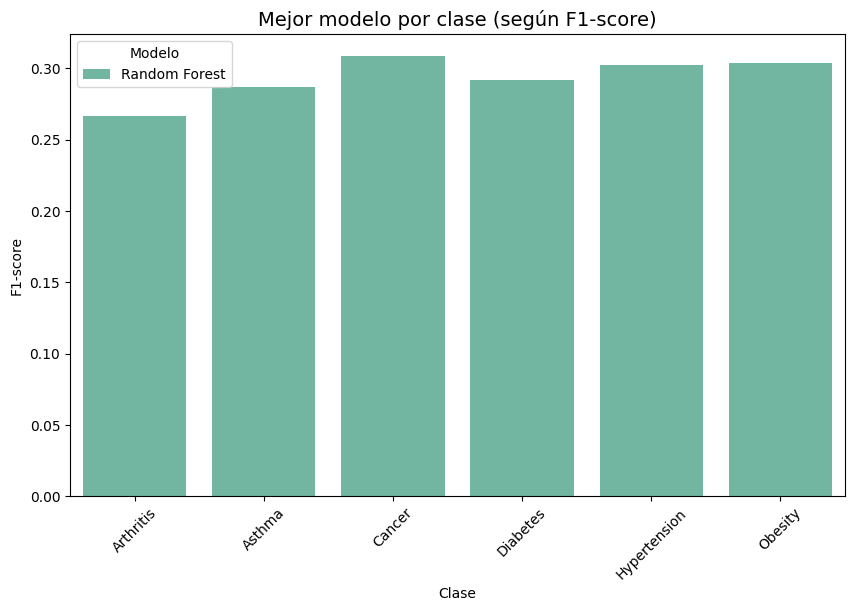

In [ ]:
# ======================================================
# Ranking de ganadores por clase
# ======================================================

# Para cada clase, identificar el modelo con mayor F1-score
ranking = df_metricas.loc[df_metricas.groupby("Clase")["F1-score"].idxmax()]

# Ordenar por clase para mayor claridad
ranking = ranking.sort_values(by="Clase").reset_index(drop=True)

print("🏆 Ranking de ganadores por clase:")
print(ranking[["Clase", "Modelo", "F1-score"]])

# Visualización del ranking
plt.figure(figsize=(10,6))
sns.barplot(data=ranking, x="Clase", y="F1-score", hue="Modelo", palette="Set2")
plt.title("Mejor modelo por clase (según F1-score)", fontsize=14)
plt.ylabel("F1-score")
plt.xticks(rotation=45)
plt.legend(title="Modelo")
plt.show()


/tmp/ipython-input-2652723236.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=features[indices], palette="viridis")


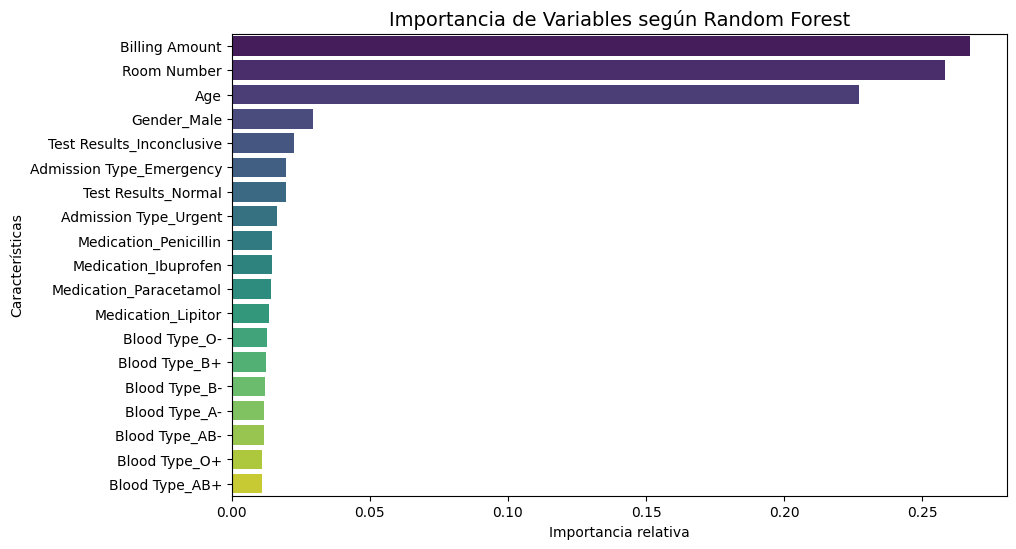

In [ ]:
# 7. Interpretación del Modelo: Importancia de Variables
# ------------------------------------------------------

# Extraer la importancia de características del modelo Random Forest
importances = rf.feature_importances_
features = X_train.columns

# Ordenar de mayor a menor importancia
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=features[indices], palette="viridis")
plt.title("Importancia de Variables según Random Forest", fontsize=14)
plt.xlabel("Importancia relativa")
plt.ylabel("Características")
plt.show()
